The goal of this notebook is to utilze our superpixel segmentation and the aggregated means of the each image within our datacube to train a random forest and classify our area of interest. The workflow is exactly as it was probing our labeled polygons in a previous notebook; instead of using labeled polygons, we use the superpixel segments. We apply the library [`rasterstats`](https://pythonhosted.org/rasterstats/manual.html#user-defined-statistics) for this aggregation; note this takes some time.

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rasterstats import zonal_stats
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Set Path Variables

In [2]:
data_path_name = 'data/tif_datacube/'
data_path = Path(data_path_name)
data_path.exists()

True

In [3]:
tif_paths = sorted(list(data_path.glob('*.tif')))
tif_paths

[PosixPath('data/tif_datacube/ALOS_RTC_2009_06_30_HH.tif'),
 PosixPath('data/tif_datacube/ALOS_RTC_2009_06_30_HV.tif'),
 PosixPath('data/tif_datacube/Hansen_GFC2015_last_10N_000E.tif'),
 PosixPath('data/tif_datacube/Hansen_GFC2015_treecover2000_10N_000E.tif')]

In [4]:
output_path_name = 'out'
out_path = Path(output_path_name)
out_path.mkdir(exist_ok=True, parents=True)

# Read the Label Data

These polygonal training data are made using QGIS, so could easily be adapted for other sites.

In [5]:
label_data_path_name = 'data/labeled_data'
label_data_df = gpd.read_file(label_data_path_name)
label_data_df.head()

,class_id,class_name,geometry
0,0,forest,"POLYGON ((551360.6065915036 10060340.66369013,..."
1,1,water,"POLYGON ((555959.6271165322 10065712.31966336,..."
2,0,forest,"POLYGON ((558005.356285607 10057986.22742318, ..."
3,1,water,"POLYGON ((559270.2815323016 10063734.63547241,..."
4,2,mangroves,"POLYGON ((554620.5544992845 10062731.12009447,..."


We have `class_id` (int) and we want a dictionary that translates that to the `class_name` associated with the land cover class.

In [6]:
label_data_df.dissolve('class_id')
class_id_dict = label_data_df.set_index('class_id')['class_name'].to_dict()
class_id_dict

{0: 'forest', 1: 'water', 2: 'mangroves'}

# Read the Superpixel Vector Data

In [7]:
superpixels_path = str(out_path/'superpixels')
superpixel_df = gpd.read_file(superpixels_path)
superpixel_df.head()

,label,geometry
0,2,"POLYGON ((551147.625 10069853.25, 551160.125 1..."
1,7,"POLYGON ((551660.125 10069853.25, 551785.125 1..."
2,10,"POLYGON ((551897.625 10069853.25, 551910.125 1..."
3,14,"POLYGON ((552210.125 10069853.25, 552347.625 1..."
4,23,"POLYGON ((552885.125 10069853.25, 553360.125 1..."


We will plot it, though the region of interest is so large that's its hard to get an idea of how well the segments are capturing the features. Better to open in QGIS.

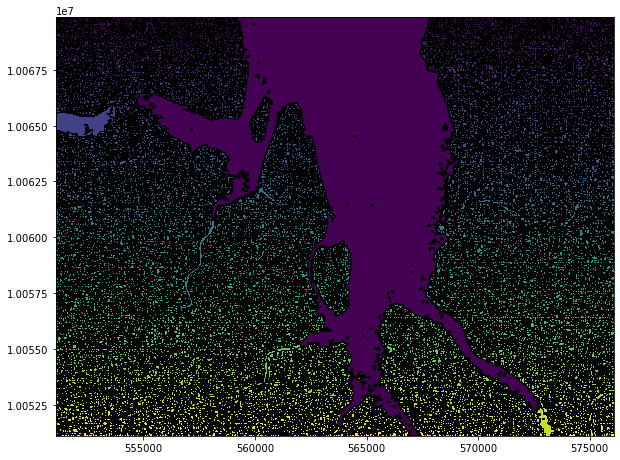

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
with rasterio.open(tif_paths[0]) as ds:
    show(ds, vmin=0, vmax=.5, ax=ax)
    superpixel_df.plot(ax=ax, column='label', edgecolor='black', facecolor=(0, 0, 0, 0))

# Populating Segments

We use [`rasterstats`](https://pythonhosted.org/rasterstats/_modules/rasterstats/main.html) to populate each of the segments with the mean from our datacube.

**Warning 1**: `rasterstats` is not as fast as using scipy, though much more transparent from the user-perspective.

**Warning 2**: the rasters do not have `nodata` areas. If they did, I would likely set them to `np.nan` and [user-defined statistics](https://pythonhosted.org/rasterstats/manual.html#user-defined-statistics), with `np.nanmean`.

## PALSAR

Note that we use the most recent of the available PALSAR images.

In [9]:
%%time

zonal_stats_hh = zonal_stats(superpixel_df, tif_paths[0], stats='mean')
zonal_stats_hh = [{'mean_hh': data['mean']} for data in zonal_stats_hh]
df_hh_superpixels = pd.DataFrame(zonal_stats_hh)

CPU times: user 1min 49s, sys: 9.13 s, total: 1min 58s
Wall time: 1min 56s


In [10]:
%%time

zonal_stats_hv = zonal_stats(superpixel_df, tif_paths[1], stats='mean')
zonal_stats_hv = [{'mean_hv': data['mean']} for data in zonal_stats_hv]
df_hv_superpixels = pd.DataFrame(zonal_stats_hv)

CPU times: user 1min 48s, sys: 9.13 s, total: 1min 57s
Wall time: 1min 56s


## Landsat

In [11]:
%%time

zonal_stats_red = zonal_stats(superpixel_df, tif_paths[2], stats='mean', band=1)
zonal_stats_red = [{'mean_red': data['mean']} for data in zonal_stats_red]
df_red_superpixels = pd.DataFrame(zonal_stats_red)

/Users/cmarshak/anaconda3/lib/python3.7/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


CPU times: user 2min 4s, sys: 9.84 s, total: 2min 14s
Wall time: 2min 12s


In [12]:
%%time

zonal_stats_green = zonal_stats(superpixel_df, tif_paths[2], stats='mean', band=2)
zonal_stats_green = [{'mean_green': data['mean']} for data in zonal_stats_green]
df_green_superpixels = pd.DataFrame(zonal_stats_green)

CPU times: user 2min 1s, sys: 8.84 s, total: 2min 10s
Wall time: 2min 8s


In [13]:
%%time

zonal_stats_blue = zonal_stats(superpixel_df, tif_paths[2], stats='mean', band=3)
zonal_stats_blue = [{'mean_blue': data['mean']} for data in zonal_stats_blue]
df_blue_superpixels = pd.DataFrame(zonal_stats_blue)

CPU times: user 2min, sys: 8.56 s, total: 2min 9s
Wall time: 2min 7s


## Combining Zonal Stats into Superpixel GeoDataframe

In [14]:
superpixel_analysis_df = pd.concat([superpixel_df,
                                    df_hh_superpixels,
                                    df_hv_superpixels,
                                    df_red_superpixels,
                                    df_green_superpixels,
                                    df_blue_superpixels], axis=1)
superpixel_analysis_df.head()

,label,geometry,mean_hh,mean_hv,mean_red,mean_green,mean_blue
0,2,"POLYGON ((551147.625 10069853.25, 551160.125 1...",0.091078,0.032831,12.800000,55.400000,47.800000
1,7,"POLYGON ((551660.125 10069853.25, 551785.125 1...",0.275345,0.086483,8.540541,62.837838,45.351351
2,10,"POLYGON ((551897.625 10069853.25, 551910.125 1...",0.064401,0.036849,14.000000,44.000000,39.000000
3,14,"POLYGON ((552210.125 10069853.25, 552347.625 1...",0.204254,0.053151,11.769231,52.923077,37.025641
4,23,"POLYGON ((552885.125 10069853.25, 553360.125 1...",0.183840,0.046818,13.231579,42.947368,28.852632


## Adding `db` column 

In [15]:
superpixel_analysis_df['mean_hh_db'] = superpixel_analysis_df['mean_hh'].map(lambda val: 10 * np.log10(val))
superpixel_analysis_df['mean_hv_db'] = superpixel_analysis_df['mean_hv'].map(lambda val: 10 * np.log10(val))
superpixel_analysis_df.head()

,label,geometry,mean_hh,mean_hv,mean_red,mean_green,mean_blue,mean_hh_db,mean_hv_db
0,2,"POLYGON ((551147.625 10069853.25, 551160.125 1...",0.091078,0.032831,12.800000,55.400000,47.800000,-10.405877,-14.837131
1,7,"POLYGON ((551660.125 10069853.25, 551785.125 1...",0.275345,0.086483,8.540541,62.837838,45.351351,-5.601224,-10.630683
2,10,"POLYGON ((551897.625 10069853.25, 551910.125 1...",0.064401,0.036849,14.000000,44.000000,39.000000,-11.911076,-14.335755
3,14,"POLYGON ((552210.125 10069853.25, 552347.625 1...",0.204254,0.053151,11.769231,52.923077,37.025641,-6.898287,-12.744926
4,23,"POLYGON ((552885.125 10069853.25, 553360.125 1...",0.183840,0.046818,13.231579,42.947368,28.852632,-7.355598,-13.295843


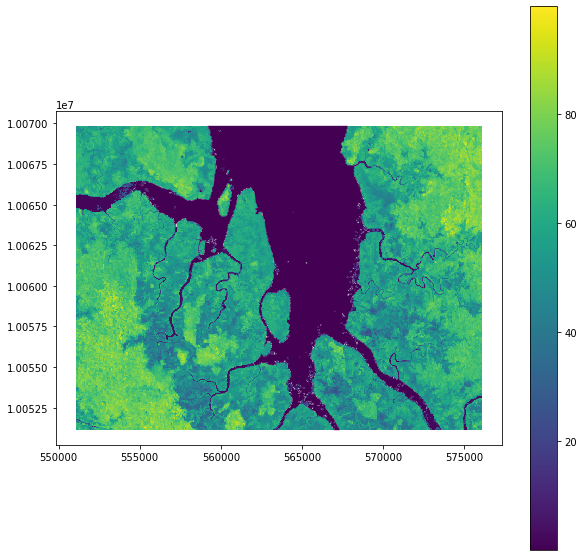

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
superpixel_analysis_df.plot(ax=ax, column='mean_green', legend=True)

We save our new geodataframe as a shapefile (or GeoJSON). However, it will take some time to write with so many columns.

In [17]:
superpixel_analysis_df.to_file(out_path/'superpixels_with_attributes')

/Users/cmarshak/anaconda3/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


# Finding Training Superpixels

We first consider the segments that overlap with our label geometries. The code below finds all superpixel segments that intersect the label geometries and removes those that do not.

In [18]:
label_geometry = label_data_df.geometry.unary_union
df_intersect = gpd.sjoin(superpixel_analysis_df, label_data_df, how='inner', op='intersects')
df_intersect.head()

,label,geometry,mean_hh,mean_hv,mean_red,mean_green,mean_blue,mean_hh_db,mean_hv_db,index_right,class_id,class_name
17351,10283,"POLYGON ((554710.125 10062890.75, 554722.625 1...",0.387994,0.071979,16.016129,49.193548,43.500000,-4.111747,-11.427956,4,2,mangroves
17352,10261,"POLYGON ((554760.125 10062915.75, 554772.625 1...",0.284443,0.043907,15.138614,48.673267,40.752475,-5.460049,-13.574614,4,2,mangroves
17457,10526,"POLYGON ((554597.625 10062765.75, 554622.625 1...",0.363042,0.079464,13.530612,52.530612,40.102041,-4.400426,-10.998294,4,2,mangroves
17458,10376,"POLYGON ((554647.625 10062840.75, 554710.125 1...",0.400310,0.092349,15.109756,52.963415,41.500000,-3.976041,-10.345679,4,2,mangroves
17459,10527,"POLYGON ((554960.125 10062765.75, 554985.125 1...",0.303331,0.057569,18.329545,51.193182,41.568182,-5.180830,-12.398125,4,2,mangroves


We see there are far fewer overlapping segments!

In [19]:
df_intersect.shape

(147, 12)

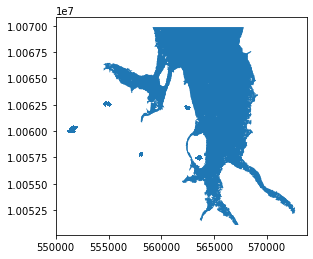

In [20]:
df_intersect.plot()

Now, let's update our superpixel dataframe with the class ids from our label data.

In [21]:
superpixel_analysis_df = pd.merge(superpixel_analysis_df, 
                                  df_intersect[['label', 'class_id']], 
                                  on='label', how='left')
superpixel_analysis_df.head()

,label,geometry,mean_hh,mean_hv,mean_red,mean_green,mean_blue,mean_hh_db,mean_hv_db,class_id
0,2,"POLYGON ((551147.625 10069853.25, 551160.125 1...",0.091078,0.032831,12.800000,55.400000,47.800000,-10.405877,-14.837131,NaN
1,7,"POLYGON ((551660.125 10069853.25, 551785.125 1...",0.275345,0.086483,8.540541,62.837838,45.351351,-5.601224,-10.630683,NaN
2,10,"POLYGON ((551897.625 10069853.25, 551910.125 1...",0.064401,0.036849,14.000000,44.000000,39.000000,-11.911076,-14.335755,NaN
3,14,"POLYGON ((552210.125 10069853.25, 552347.625 1...",0.204254,0.053151,11.769231,52.923077,37.025641,-6.898287,-12.744926,NaN
4,23,"POLYGON ((552885.125 10069853.25, 553360.125 1...",0.183840,0.046818,13.231579,42.947368,28.852632,-7.355598,-13.295843,NaN


Now we are going to add a column denoting if those segments are labeled in the sense they overlap with one of our geometries.

In [22]:
# creating a column to specify if the segment is labeled
# the nan values indicate no labels
# the "~" is short for "not"
labeled_ind = ~np.isnan(superpixel_analysis_df.class_id.values)
superpixel_analysis_df['labeled'] = 0
superpixel_analysis_df.loc[labeled_ind, 'labeled'] = 1

# display geodataframe
superpixel_analysis_df.head()

,label,geometry,mean_hh,mean_hv,mean_red,mean_green,mean_blue,mean_hh_db,mean_hv_db,class_id,labeled
0,2,"POLYGON ((551147.625 10069853.25, 551160.125 1...",0.091078,0.032831,12.800000,55.400000,47.800000,-10.405877,-14.837131,NaN,0
1,7,"POLYGON ((551660.125 10069853.25, 551785.125 1...",0.275345,0.086483,8.540541,62.837838,45.351351,-5.601224,-10.630683,NaN,0
2,10,"POLYGON ((551897.625 10069853.25, 551910.125 1...",0.064401,0.036849,14.000000,44.000000,39.000000,-11.911076,-14.335755,NaN,0
3,14,"POLYGON ((552210.125 10069853.25, 552347.625 1...",0.204254,0.053151,11.769231,52.923077,37.025641,-6.898287,-12.744926,NaN,0
4,23,"POLYGON ((552885.125 10069853.25, 553360.125 1...",0.183840,0.046818,13.231579,42.947368,28.852632,-7.355598,-13.295843,NaN,0


We now can see how many labeled/unlabeled segments we have based on those with class ids that are integers.

In [23]:
percent_labeled = np.sum(superpixel_analysis_df['labeled']) / superpixel_analysis_df.shape[0]

print(f'Percent labeled {percent_labeled * 100:1.2f}%')

Percent labeled 0.64%


In [24]:
superpixel_analysis_df[superpixel_analysis_df.labeled == 1].to_file(out_path/'training_superpixels')

Now, we specify the column we will use for our random forest, the machine learning model we use for classification.

In [25]:
columns_for_analysis = [
                        'mean_hh', 
                        'mean_hv', 
                        'mean_red', 
                        'mean_green', 
                        'mean_blue'
                        ]

Below, the [sklearn random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), as all models, take numpy arrays. Below we convert the dataframes into matrices without row/column names. This is what `.values` provides.

In [26]:
X_labeled = superpixel_analysis_df.loc[labeled_ind, columns_for_analysis].values
y_labeled = superpixel_analysis_df.loc[labeled_ind,'class_id'].values

In [27]:
X_labeled[:10, :10], X_labeled.shape

(array([[1.02689219e-01, 2.35662619e-02, 7.86666667e+00, 1.96000000e+01,
         1.33333333e+01],
        [1.02689219e-01, 2.35662619e-02, 7.86666667e+00, 1.96000000e+01,
         1.33333333e+01],
        [6.13179896e-03, 1.62653101e-03, 9.00000000e+00, 2.80000000e+01,
         1.80000000e+01],
        [6.13179896e-03, 1.62653101e-03, 9.00000000e+00, 2.80000000e+01,
         1.80000000e+01],
        [1.08957343e-01, 1.08550489e-02, 1.00000000e+01, 3.40000000e+01,
         2.30000000e+01],
        [1.08957343e-01, 1.08550489e-02, 1.00000000e+01, 3.40000000e+01,
         2.30000000e+01],
        [3.02923781e-03, 1.29081860e-03, 1.16666667e+00, 1.25000000e+00,
         1.25000000e+00],
        [3.02923781e-03, 1.29081860e-03, 1.16666667e+00, 1.25000000e+00,
         1.25000000e+00],
        [1.97542176e-01, 1.89613588e-02, 9.75000000e+00, 3.35000000e+01,
         2.22500000e+01],
        [1.97542176e-01, 1.89613588e-02, 9.75000000e+00, 3.35000000e+01,
         2.22500000e+01]]),
 (356, 5

# Train and Test Split of our Labeled Data

We have labeled data, but we don't want to train our model on all of the points so that we can see how "general" our model is. In other words, we not only want our model to do well on the points it is trained on, but also on those it wasn't. This also provides us a way to benchmark our model. For more information, here is a wikipedia article on [train/validation](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets) in machine learning. In our case, we hold out 25% of the labeled data for our validation set.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_labeled, 
                                                    y_labeled, 
                                                    test_size=0.25, 
                                                    random_state=0)

The [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) has a number of parameters that you can read about in the docs. We are using 500 decision trees and evaluating their performance using unseen examples within the training data. The final classifications are the majority determination from all of these trees.

In [29]:
rf = RandomForestClassifier(n_estimators=500,
                            oob_score=True,
                            # This ensures the output of our model is the same each run
                            random_state=0)

First, we train the model:

In [30]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

Now, we evaluate the performance on the validation set:

In [31]:
y_pred = rf.predict(X_test)

Let's evaluate the model on the validation set using the confusion matrix.

In [32]:
y_pred_str = pd.Series([class_id_dict[class_id] for class_id in y_pred], name='Predicted')
y_true_str = pd.Series([class_id_dict[class_id] for class_id in y_test], name='True')

In [33]:
df_confusion = pd.crosstab(y_true_str, y_pred_str)
df_confusion

Predicted,forest,mangroves,water
True,,,
forest,26,0,0
mangroves,0,39,0
water,0,0,24


# Applying to the Full Area

We now apply the model to all the *unlabeled* areas. Again note the "~" means "not". So below, we take all the rows that are "not labeled".

In [34]:
X_unlabeled = superpixel_analysis_df.loc[~labeled_ind, columns_for_analysis].values
y_pred_unlabeled = rf.predict(X_unlabeled)

In [35]:
superpixel_analysis_df.loc[~labeled_ind, 'class_id'] = y_pred_unlabeled
superpixel_analysis_df.head()

,label,geometry,mean_hh,mean_hv,mean_red,mean_green,mean_blue,mean_hh_db,mean_hv_db,class_id,labeled
0,2,"POLYGON ((551147.625 10069853.25, 551160.125 1...",0.091078,0.032831,12.800000,55.400000,47.800000,-10.405877,-14.837131,0.0,0
1,7,"POLYGON ((551660.125 10069853.25, 551785.125 1...",0.275345,0.086483,8.540541,62.837838,45.351351,-5.601224,-10.630683,2.0,0
2,10,"POLYGON ((551897.625 10069853.25, 551910.125 1...",0.064401,0.036849,14.000000,44.000000,39.000000,-11.911076,-14.335755,2.0,0
3,14,"POLYGON ((552210.125 10069853.25, 552347.625 1...",0.204254,0.053151,11.769231,52.923077,37.025641,-6.898287,-12.744926,2.0,0
4,23,"POLYGON ((552885.125 10069853.25, 553360.125 1...",0.183840,0.046818,13.231579,42.947368,28.852632,-7.355598,-13.295843,2.0,0


Let's now add the class names back to the superpixel array so we can plot it in a human-readable format.

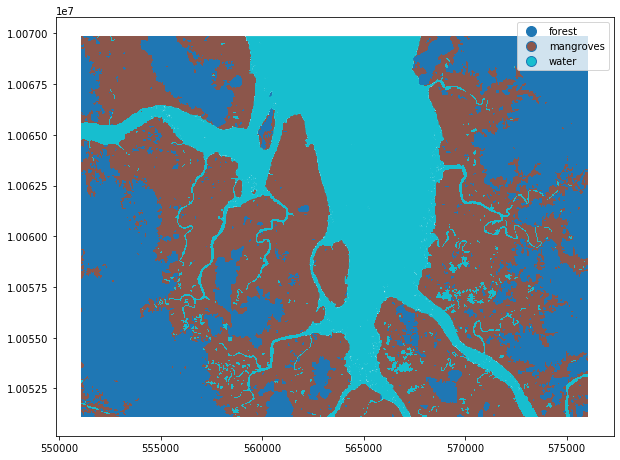

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
def namer(class_id):
    return class_id_dict[class_id]
superpixel_analysis_df['class_name'] = superpixel_analysis_df.class_id.map(namer)
superpixel_analysis_df.plot(column='class_name', ax=ax, legend=True)

Now, we will save our classification. So it's easier to view in QGIS, we are going to [`dissolve`](https://geopandas.org/aggregation_with_dissolve.html) the geometries according to their class. That way we can see the boundaries of each class more easily. We have to buffer our geometries because some of the geometries are only connected by a single point (diagonal adjacency) and this will cause an error without a buffer.

In [37]:
superpixel_analysis_df.geometry = superpixel_analysis_df.geometry.buffer(1e-5)
class_df = superpixel_analysis_df.dissolve(by='class_name')

In [38]:
class_df.reset_index(inplace=True)
class_df.to_file(out_path/'classification')

/Users/cmarshak/anaconda3/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
